### Libraries Import

In [38]:
# Importa todas as bibliotecas
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import os
import tensorflow as tf
from keras import layers
from keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import re
from scipy.ndimage import zoom

### Hiperparameters Configuration

In [ ]:
# --- Hiperparâmetros do Transformer ---
PROJECTION_DIM = 768
NUM_HEADS = 12
TRANSFORMER_LAYERS = 8
MLP_DIM = 3072
DROPOUT = 0.3

# --- Hiperparâmetros para o ViT 2D ---
INPUT_SHAPE_2D = (233, 197, 1)
PATCH_SIZE = 32
CHANNELS = INPUT_SHAPE_2D[2]

# Calcular o número de patches
NUM_PATCHES_H = INPUT_SHAPE_2D[0] // PATCH_SIZE
NUM_PATCHES_W = INPUT_SHAPE_2D[1] // PATCH_SIZE
NUM_PATCHES = NUM_PATCHES_H * NUM_PATCHES_W

# Dimensão de cada patch 2D achatado (40*40*1 = 1600)
PATCH_DIM_2D = (PATCH_SIZE * PATCH_SIZE * CHANNELS)

### Auxiliar Functions

In [43]:
def load_data(image_dir, mask_dir):
    """
    Encontra e pareia os caminhos das imagens com suas 
    respectivas máscaras de segmentação, adicionando o ID do paciente.
    """
    file_list = []
    image_patient_dirs = sorted(os.listdir(image_dir)) # Diretórios dos pacientes (ex: sub-00H10)
    mask_patient_dirs = sorted(os.listdir(mask_dir))

    # Verifica se os diretórios de pacientes correspondem
    if image_patient_dirs != mask_patient_dirs:
        print("Aviso: Nomes de diretórios de pacientes em image e mask não são idênticos.")
        # Pode precisar de lógica adicional para parear corretamente se os nomes diferem

    for patient_id in image_patient_dirs: # Usa a lista de imagens como referência
        image_path = os.path.join(image_dir, patient_id)
        mask_path = os.path.join(mask_dir, patient_id) # Assume mesmo nome de subdiretório

        # Verifica se ambos são diretórios
        if not os.path.isdir(image_path) or not os.path.isdir(mask_path):
            # print(f"Aviso: {patient_id} não é um diretório válido em ambas as pastas. Pulando.")
            continue # Pula se não for diretório em ambos

        try:
            image_datas = sorted(os.listdir(image_path))
            mask_datas = sorted(os.listdir(mask_path))

            # Pareia os arquivos de fatia dentro do diretório do paciente
            mask_data_dict = {f: os.path.join(mask_path, f) for f in mask_datas}

            for image_data in image_datas:
                image_file_path = os.path.join(image_path, image_data)
                mask_file_path = mask_data_dict.get(image_data) # Procura máscara com mesmo nome

                if mask_file_path and os.path.exists(mask_file_path):
                    # Ler a máscara para determinar o rótulo da fatia
                    mask_itk = sitk.ReadImage(mask_file_path)
                    mask_np = sitk.GetArrayFromImage(mask_itk)
                    label = 1 if np.sum(mask_np) > 0 else 0

                    file_list.append({
                        "image": image_file_path,
                        "mask": mask_file_path,
                        "label": label,
                        "paciente": patient_id
                    })
        except FileNotFoundError:
             print(f"Aviso: Diretório não encontrado ou problema ao listar arquivos para paciente {patient_id}. Pulando.")
        except Exception as e:
             print(f"Erro processando paciente {patient_id}: {e}")

    return file_list


In [ ]:
# --- Bloco Transformer (Copiado da sua Célula 5) ---
def build_transformer_block(x, num_heads, projection_dim, mlp_dim, dropout=DROPOUT):
    residual_1 = x
    x_norm1 = layers.LayerNormalization(epsilon=1e-6)(x)
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, 
        key_dim=projection_dim // num_heads, 
        dropout=dropout
    )(x_norm1, x_norm1)
    x = layers.Add()([attention_output, residual_1])
    
    residual_2 = x
    x_norm2 = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dense(mlp_dim, activation="gelu")(x_norm2)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(projection_dim)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Add()([x, residual_2])
    return x

# --- NOVA Função: ViT 2D Clássico ---
def build_vit_2d_classic(input_shape=INPUT_SHAPE_2D, 
                                 patch_size=PATCH_SIZE, 
                                 num_patches=NUM_PATCHES, 
                                 projection_dim=PROJECTION_DIM, 
                                 transformer_layers=TRANSFORMER_LAYERS,
                                 mlp_dim=MLP_DIM,
                                 num_heads=NUM_HEADS):
    """
    Constrói um modelo ViT 2D clássico para classificação de fatias.
    """
    
    inputs = layers.Input(shape=input_shape)
    
    # 1. Patching + Projeção Linear (usando Conv2D)
    patches = layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding="VALID",
        name="patch_projection"
    )(inputs)
    
    # 2. Achatar os patches de (H, W, C) para (N, C)
    patches_flat = layers.Reshape((num_patches, projection_dim), name="flatten_patches")(patches)
    
    # 3. Adicionar Positional Embedding
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = layers.Embedding(
        input_dim=num_patches, 
        output_dim=projection_dim,
        name="positional_embedding"
    )(positions)
    
    encoded_patches = patches_flat + position_embedding
    
    # 4. Pilha de Encoders Transformer
    x = encoded_patches
    for i in range(transformer_layers):
        x = build_transformer_block(x, num_heads, projection_dim, mlp_dim)
        
    # 5. Cabeça de Classificação (Head)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x) # Saída binária
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [4]:
# Função de plot do treinamento do modelo
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Função de plot da matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


### Images Loading

In [44]:
# Carregar os pares de caminhos
IMAGE_DIR = "Fatias_Patients"
MASK_DIR = "Fatias_Mask"

file_list_original = load_data(IMAGE_DIR, MASK_DIR)

### Class Division

In [49]:
# --- Carregar os dados ---
IMAGE_DIR = "Fatias_Patients"
MASK_DIR = "Fatias_Mask"
file_list_original = load_data(IMAGE_DIR, MASK_DIR)

# 1. Obter lista de pacientes únicos
patient_ids = sorted(list(set(item['paciente'] for item in file_list_original)))
num_patients = len(patient_ids)
print(f"\nTotal de pacientes únicos encontrados: {num_patients}")

# 2. Dividir os IDs dos pacientes
train_val_ids, test_ids = train_test_split(
    patient_ids,
    test_size=0.09,
    random_state=42
)

# Depois, divide o restante (90%) em treino (~70% do total) e validação (~20% do total)
train_ids, val_ids = train_test_split(
    train_val_ids,
    test_size=0.21,
    random_state=42
)

# Converte as listas de IDs em sets para busca rápida
train_ids_set = set(train_ids)
val_ids_set = set(val_ids)
test_ids_set = set(test_ids)

# 3. Criar as listas de fatias baseadas nos IDs dos pacientes divididos
train_files = []
val_files = []
test_files = []

for item in file_list_original:
    patient_id = item['paciente']
    if patient_id in train_ids_set:
        train_files.append(item)
    elif patient_id in val_ids_set:
        val_files.append(item)
    elif patient_id in test_ids_set:
        test_files.append(item)

# 4. Imprimir os resultados e as listas de pacientes
print("\n--- Divisão por Pacientes ---")
print(f"Pacientes de Treino ({len(train_ids)}): {sorted(train_ids)}")
print(f"Pacientes de Validação ({len(val_ids)}): {sorted(val_ids)}")
print(f"Pacientes de Teste ({len(test_ids)}): {sorted(test_ids)}")

print("\n--- Divisão por Fatias ---")
print(f"Fatias de Treino: {len(train_files)}")
print(f"Fatias de Validação: {len(val_files)}")
print(f"Fatias de Teste: {len(test_files)}")

# Verifica se todas as fatias foram distribuídas
total_fatias_divididas = len(train_files) + len(val_files) + len(test_files)
print(f"Total de fatias original: {len(file_list_original)}")
print(f"Total de fatias divididas: {total_fatias_divididas}")
if total_fatias_divididas != len(file_list_original):
    print("!!! ATENÇÃO: Nem todas as fatias foram distribuídas corretamente !!!")

# 5. Verificar balanceamento dentro de cada conjunto de fatias
train_labels = [item['label'] for item in train_files]
val_labels = [item['label'] for item in val_files]
test_labels = [item['label'] for item in test_files]

print("\n--- Balanceamento das Fatias (Label 1 / Total) ---")
print(f"Treino: {np.sum(train_labels)} / {len(train_labels)} ({np.mean(train_labels)*100:.1f}%)")
print(f"Validação: {np.sum(val_labels)} / {len(val_labels)} ({np.mean(val_labels)*100:.1f}%)")
print(f"Teste: {np.sum(test_labels)} / {len(test_labels)} ({np.mean(test_labels)*100:.1f}%)")


Total de pacientes únicos encontrados: 41

--- Divisão por Pacientes ---
Pacientes de Treino (29): ['sub-00H10', 'sub-02A13', 'sub-03C08', 'sub-14F04', 'sub-16G09', 'sub-16I12', 'sub-19G04', 'sub-25B08', 'sub-26B09', 'sub-31F07', 'sub-34J06', 'sub-35E12', 'sub-36K02', 'sub-41D08', 'sub-42B05', 'sub-42K06', 'sub-44H05', 'sub-51C05', 'sub-52K04', 'sub-59G00', 'sub-60K04', 'sub-71C07', 'sub-72I02', 'sub-72K02', 'sub-76E02', 'sub-83K08', 'sub-85I05', 'sub-86B13', 'sub-86G08']
Pacientes de Validação (8): ['sub-06C09', 'sub-16E03', 'sub-22F14', 'sub-59E09', 'sub-60G06', 'sub-60G13', 'sub-76J09', 'sub-79H07']
Pacientes de Teste (4): ['sub-19F09', 'sub-29D03', 'sub-56E13', 'sub-57D04']

--- Divisão por Fatias ---
Fatias de Treino: 3916
Fatias de Validação: 1072
Fatias de Teste: 546
Total de fatias original: 5534
Total de fatias divididas: 5534

--- Balanceamento das Fatias (Label 1 / Total) ---
Treino: 1027 / 3916 (26.2%)
Validação: 296 / 1072 (27.6%)
Teste: 185 / 546 (33.9%)


### Model Preparation + Training

In [ ]:
def _read_nifti_2d(path):
    """
    Função helper para ler e redimensionar fatias 2D NIfTI.
    """
    path = path.numpy().decode('utf-8')
    
    nifti_image = nib.load(path).get_fdata().astype(np.float32)
    
    # Garantir que a imagem é 2D (remove eixos unitários, ex: (256, 256, 1) -> (256, 256))
    if nifti_image.ndim > 2:
        nifti_image = np.squeeze(nifti_image)
    
    if nifti_image.ndim != 2:
        raise ValueError(f"Imagem não é 2D após squeeze: {path} com shape {nifti_image.shape}")
    
    return nifti_image

def load_and_preprocess_image(image_path, label):
    """
    Carrega e pré-processa uma fatia 2D para o modelo.
    """
    image = tf.py_function(
        func=_read_nifti_2d, 
        inp=[image_path], 
        Tout=tf.float32
    )

    image.set_shape([None,None])

    # (H, W) -> (H, W, 1)
    image = tf.expand_dims(image, axis=-1)

    # Normalizar imagem
    image = image / (tf.reduce_max(image) + 1e-6) 
    
    # Definir a forma final esperada pelo modelo
    image.set_shape(INPUT_SHAPE_2D)
    
    return image, label

In [50]:
train_paths = [item['image'] for item in train_files]
train_labels = [item['label'] for item in train_files]
val_paths = [item['image'] for item in val_files]
val_labels = [item['label'] for item in val_files]
test_paths = [item['image'] for item in test_files]
test_labels = [item['label'] for item in test_files]

# Definir o batch_size
batch_size = 16

# Criar o dataset de treino com .batch()
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar o dataset de validação com .batch()
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Criar o dataset de teste com .batch()
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
# Construir o modelo ViT clássico
model = build_vit_2d_classic(
    INPUT_SHAPE_2D
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 233, 197, 1) 0                                            
__________________________________________________________________________________________________
patch_projection (Conv2D)       (None, 7, 6, 768)    787200      input_2[0][0]                    
__________________________________________________________________________________________________
flatten_patches (Reshape)       (None, 42, 768)      0           patch_projection[0][0]           
__________________________________________________________________________________________________
tf.__operators__.add_1 (TFOpLam (None, 42, 768)      0           flatten_patches[0][0]            
____________________________________________________________________________________________

In [53]:
# Compilando o modelo híbrido
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
)

# Histórico do treinamento
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50)

print("Treinamento concluído.")

Epoch 1/50
245/245 [==============================] - 36s 123ms/step - loss: 0.5862 - accuracy: 0.7178 - precision: 0.3107 - recall: 0.0623 - val_loss: 0.6066 - val_accuracy: 0.6353 - val_precision: 0.3733 - val_recall: 0.4730
Epoch 2/50
245/245 [==============================] - 51s 209ms/step - loss: 0.5397 - accuracy: 0.7293 - precision: 0.4240 - recall: 0.0896 - val_loss: 0.6048 - val_accuracy: 0.7239 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
245/245 [==============================] - 58s 234ms/step - loss: 0.5277 - accuracy: 0.7375 - precision: 0.4976 - recall: 0.0993 - val_loss: 0.6098 - val_accuracy: 0.7239 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
245/245 [==============================] - 56s 229ms/step - loss: 0.5296 - accuracy: 0.7303 - precision: 0.4190 - recall: 0.0730 - val_loss: 0.5919 - val_accuracy: 0.7239 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
245/245 [==============================] - 57s 235ms/step

### Evaluation of the model training

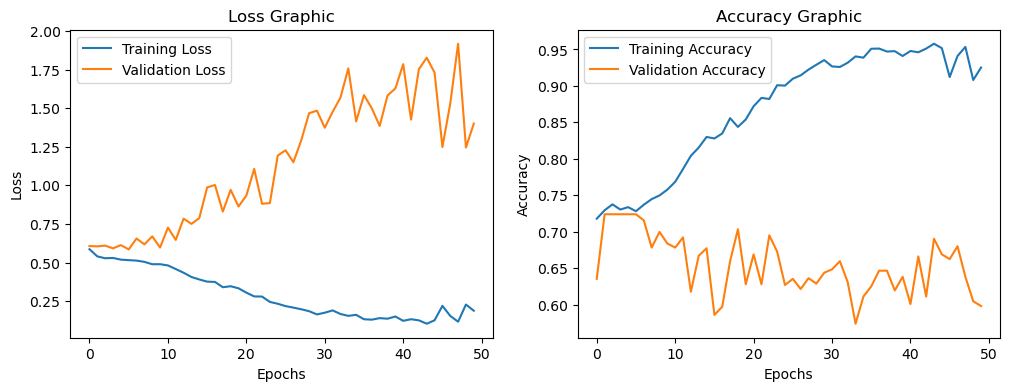

In [54]:
plot_training_history(history)

Validação:
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       776
           1       0.29      0.31      0.30       296

    accuracy                           0.60      1072
   macro avg       0.51      0.51      0.51      1072
weighted avg       0.61      0.60      0.60      1072


#########################################################

Teste:
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       361
           1       0.34      0.25      0.29       185

    accuracy                           0.58       546
   macro avg       0.50      0.50      0.50       546
weighted avg       0.55      0.58      0.56       546

Validação:


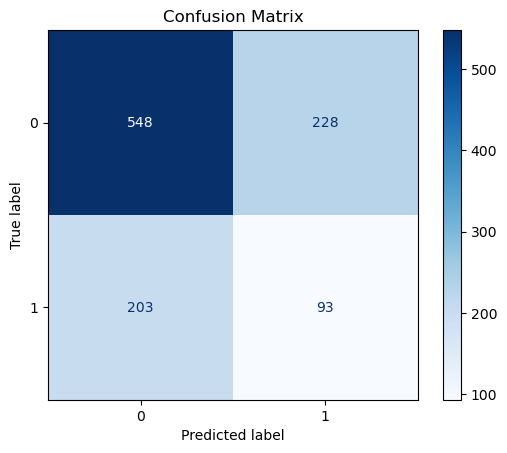

Teste:


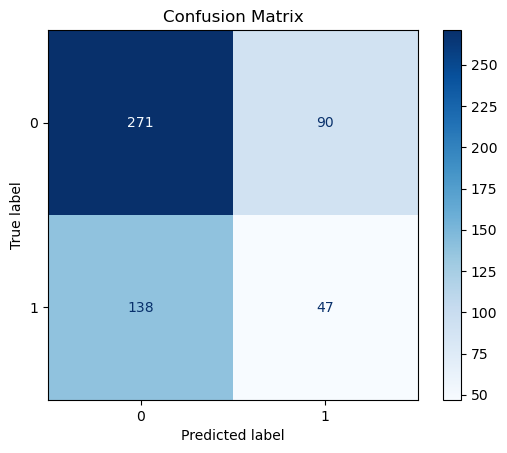

In [55]:
# Avaliar o modelo na validação e teste
y_pred_valid = (model.predict(val_dataset) > 0.5).astype(int)
y_pred_test = (model.predict(test_dataset) > 0.5).astype(int)

# Gerar o relatório de classificação
print("Validação:")
print(classification_report(val_labels, y_pred_valid))
print("\n#########################################################\n")

print("Teste:")
print(classification_report(test_labels, y_pred_test)) 

# Gerar a matriz de confusão
print("Validação:")
plot_confusion_matrix(val_labels, y_pred_valid)
print("Teste:")
plot_confusion_matrix(test_labels, y_pred_test)

### PDF Plot of Predictions

In [56]:
TARGET_SHAPE_3D_NEW = (233,197,150)
%matplotlib inline

def _read_nifti_2d(path_input): # Nome do argumento mudado para clareza
    """
    Função helper para ler e redimensionar fatias 2D NIfTI. 
    Aceita string ou tensor tf.string como entrada.
    Retorna array NumPy np.float32.
    """
    default_return = np.zeros((233, 197), dtype=np.float32) # Retorno padrão 2D

    try:
        # *** INÍCIO DA CORREÇÃO: Verifica o tipo de entrada ***
        if isinstance(path_input, tf.Tensor):
            # Se for tensor, decodifica
            path = path_input.numpy().decode('utf-8')
        elif isinstance(path_input, bytes):
             # Se for bytes, decodifica
             path = path_input.decode('utf-8')
        elif isinstance(path_input, str):
            # Se já for string, usa diretamente
            path = path_input
        else:
            print(f"Erro _read_nifti_2d: Tipo de entrada inesperado para path: {type(path_input)}. Retornando zeros.")
            return default_return
        # *** FIM DA CORREÇÃO ***

        # --- Carregamento ---
        try:
            nifti_img_obj = nib.load(path)
            nifti_image = nifti_img_obj.get_fdata(dtype=np.float64)
        except FileNotFoundError:
            print(f"Erro _read_nifti_2d: Arquivo não encontrado - {path}. Retornando zeros.")
            return default_return
        except Exception as e:
            print(f"Erro _read_nifti_2d ao carregar NIfTI {path}: {e}. Retornando zeros.")
            return default_return

        # --- Processamento para 2D ---
        if nifti_image.ndim > 2:
            nifti_image = np.squeeze(nifti_image)
        if nifti_image.ndim != 2:
            print(f"Erro _read_nifti_2d: Imagem não é 2D após squeeze: {path} com shape {nifti_image.shape}. Retornando zeros.")
            return default_return

        # --- Redimensionamento ---
        if nifti_image.shape != (233, 197):
             try:
                 zoom_factors_2d = [233 / nifti_image.shape[0], 197 / nifti_image.shape[1]]
                 resized_image = zoom(nifti_image, zoom_factors_2d, order=1, mode='nearest')
                 if resized_image.shape != (233, 197):
                      print(f"Aviso _read_nifti_2d: Forma após zoom 2D ({resized_image.shape}) != target. Retornando zeros.")
                      return default_return
                 nifti_image = resized_image
             except Exception as e:
                 print(f"Erro _read_nifti_2d durante o zoom 2D em {path}: {e}. Retornando zeros.")
                 return default_return

        return nifti_image.astype(np.float32)

    except Exception as outer_e:
        path_repr = repr(path_input)
        print(f"Erro inesperado geral em _read_nifti_2d para path_input={path_repr}: {outer_e}. Retornando zeros.")
        return default_return

def _read_and_resize_nifti(path_tensor, target_shape_3d_tuple, is_mask=False):
    """
    Lê e redimensiona uma imagem NIfTI para target_shape_3d. Mais robusto.
    Garante retorno de np.float32 array.
    """
    target_shape_3d = tuple(target_shape_3d_tuple) # Garante que seja tupla
    default_return = np.zeros(target_shape_3d, dtype=np.float32) # Valor padrão em caso de erro

    try:
        path = path_tensor.numpy().decode('utf-8')
        # print(f"Processing: {path}") # Descomente para debug

        # --- Carregamento ---
        try:
            nifti_img_obj = nib.load(path)
            nifti_image = nifti_img_obj.get_fdata(dtype=np.float64) 
        except FileNotFoundError:
            print(f"Erro _read_and_resize_nifti: Arquivo não encontrado - {path}. Retornando zeros.")
            return default_return
        except Exception as e:
            print(f"Erro _read_and_resize_nifti ao carregar NIfTI {path}: {e}. Retornando zeros.")
            return default_return

        # --- Redimensionamento ---
        original_shape = nifti_image.shape
        if len(original_shape) != len(target_shape_3d):
             print(f"Aviso _read_and_resize_nifti: Incompatibilidade de dimensões ({len(original_shape)}D vs {len(target_shape_3d)}D) para {path}. Retornando zeros.")
             return default_return

        try:
            zoom_factors = [
                target_shape_3d[i] / original_shape[i] for i in range(len(target_shape_3d))
            ]
        except ZeroDivisionError:
             print(f"Erro _read_and_resize_nifti: Dimensão original zero em {path} (shape: {original_shape}). Retornando zeros.")
             return default_return

        order = 0 if is_mask else 1
        
        try:
            resized_image = zoom(nifti_image, zoom_factors, order=order, mode='nearest')
        except Exception as e:
            print(f"Erro _read_and_resize_nifti durante o zoom em {path}: {e}. Retornando zeros.")
            return default_return

        # --- Verificação Final ---
        if resized_image.shape != target_shape_3d:
            print(f"Aviso _read_and_resize_nifti: Forma após zoom ({resized_image.shape}) != target ({target_shape_3d}) para {path}. Retornando zeros.")
            return default_return
            
        return resized_image.astype(np.float32)

    except Exception as outer_e:
        path_repr = repr(path_tensor) 
        print(f"Erro inesperado geral em _read_and_resize_nifti para path_tensor={path_repr}: {outer_e}. Retornando zeros.")
        return default_return


# (Inclua aqui a definição da função load_volume_and_mask_for_slices revisada da resposta anterior)
def load_volume_and_mask_for_slices(image_path, mask_path):
    """
    Carrega e pré-processa volumes IMAGEM (para 1 canal) e MÁSCARA 
    para serem usados pelo gerador de fatias. Passa target_shape como tupla.
    Retorna tensores TensorFlow.
    """
    target_shape_tuple = tuple(TARGET_SHAPE_3D_NEW) 

    # Carregar Imagem
    image = tf.py_function(
        func=_read_and_resize_nifti,
        inp=[image_path, target_shape_tuple, False], 
        Tout=tf.float32
    )
    image.set_shape(TARGET_SHAPE_3D_NEW) 
    
    # Pré-processar Imagem para 1 CANAL
    image = tf.expand_dims(image, axis=-1) 
    min_val = tf.reduce_min(image)
    max_val = tf.reduce_max(image)
    image = (image - min_val) / (max_val - min_val + tf.keras.backend.epsilon()) 
    image = tf.where(tf.math.is_nan(image), tf.zeros_like(image), image) 
    image.set_shape((*TARGET_SHAPE_3D_NEW, INPUT_SHAPE_2D[2])) 
    
    # Carregar Máscara (se existir)
    mask = tf.zeros(TARGET_SHAPE_3D_NEW, dtype=tf.float32) 
    if mask_path is not None:
        if isinstance(mask_path, str):
             mask_path_tensor = tf.constant(mask_path)
        elif isinstance(mask_path, tf.Tensor) and mask_path.dtype == tf.string:
             mask_path_tensor = mask_path
        else:
             try:
                 mask_path_tensor = tf.constant(str(mask_path))
             except: 
                 print(f"Aviso: Tipo inesperado para mask_path: {type(mask_path)}. Usando tensor vazio.")
                 mask_path_tensor = tf.constant("") 

        mask = tf.py_function(
            func=_read_and_resize_nifti, 
            inp=[mask_path_tensor, target_shape_tuple, True], 
            Tout=tf.float32
        )
        mask.set_shape(TARGET_SHAPE_3D_NEW) 

    return image, mask

def get_true_slice_labels(mask_volume_np):
    """Calcula o rótulo verdadeiro (0 ou 1) para cada fatia de um volume de máscara."""
    if mask_volume_np is None:
        num_slices = 150
        return np.zeros(num_slices, dtype=int)

    if not isinstance(mask_volume_np, np.ndarray) or not np.issubdtype(mask_volume_np.dtype, np.number):
        print(f"Aviso: mask_volume_np não é array numérico ({type(mask_volume_np)}, dtype={getattr(mask_volume_np, 'dtype', 'N/A')}). Retornando zeros.")
        num_slices = mask_volume_np.shape[2] if hasattr(mask_volume_np, 'shape') and len(mask_volume_np.shape) == 3 else 1
        return np.zeros(num_slices, dtype=int)
        
    try:
        if np.sum(mask_volume_np) < 1e-6: 
            num_slices = mask_volume_np.shape[2]
            return np.zeros(num_slices, dtype=int)
    except Exception as e: 
         print(f"Erro inesperado ao verificar soma zero: {e}. Dtype: {mask_volume_np.dtype}. Shape: {mask_volume_np.shape}. Retornando zeros.")
         num_slices = mask_volume_np.shape[2]
         return np.zeros(num_slices, dtype=int)

    try:
        slice_sums = np.sum(mask_volume_np, axis=(0, 1))
        true_labels = (slice_sums > 1e-6).astype(int) 
        return true_labels
    except Exception as e:
        print(f"Erro durante np.sum por eixo em get_true_slice_labels: {e}. Shape: {mask_volume_np.shape}, Dtype: {mask_volume_np.dtype}. Retornando zeros.")
        num_slices = mask_volume_np.shape[2]
        return np.zeros(num_slices, dtype=int)


def predict_all_slices(volume_3d_tensor, model_2d, batch_size=32):
    """
    Divide um volume 3D em fatias, pré-processa e obtém predições do modelo 2D.
    Args:
        volume_3d_tensor (tf.Tensor): Tensor da imagem 3D com shape (H, W, D, C).
        model_2d (tf.keras.Model): O modelo treinado para classificar fatias 2D.
        batch_size (int): Tamanho do lote para a predição.
    Returns:
        np.array: Array de predições (0 ou 1) para cada fatia.
    """
    num_slices = tf.shape(volume_3d_tensor)[2]
    
    # Cria um dataset temporário das fatias (D, H, W, C)
    # Transpõe o volume para iterar sobre as fatias
    try:
        # Garante que a transposição seja feita corretamente
        # A entrada para from_tensor_slices deve ter a dimensão a ser fatiada primeiro
        transposed_volume = tf.transpose(volume_3d_tensor, perm=[2, 0, 1, 3])
        # Verifica se a forma é a esperada (D, H, W, C)
        tf.debugging.assert_equal(tf.shape(transposed_volume)[1:3], [233, 197], 
                                  message="Dimensões H, W não correspondem ao esperado após transposição.")
        tf.debugging.assert_equal(tf.shape(transposed_volume)[3], INPUT_SHAPE_2D[2], 
                                  message="Número de canais não corresponde ao esperado após transposição.")

        slices_dataset = tf.data.Dataset.from_tensor_slices(transposed_volume)
        
        # Aplica batch para predição eficiente
        slices_dataset = slices_dataset.batch(batch_size)

        # Faz a predição lote a lote
        predictions_proba = model_2d.predict(slices_dataset, verbose=0) 

        # Converte probabilidades em rótulos 0 ou 1
        predicted_labels = (predictions_proba > 0.5).astype(int)
        
        # Garante que o número de predições corresponde ao número de fatias
        if len(predicted_labels) != num_slices:
             print(f"Aviso: Número de predições ({len(predicted_labels)}) não corresponde ao número de fatias ({num_slices}).")
             # Tenta redimensionar ou retorna array de -1 (indicando erro)
             # return np.full(num_slices, -1, dtype=int) # Opção de erro
             # Tenta ajustar se for um simples flatten extra:
             if len(predicted_labels.flatten()) == num_slices:
                 predicted_labels = predicted_labels.flatten()
             else: # Se não for simples, retorna erro
                  print(" -> Erro irrecuperável na forma das predições.")
                  return np.full(num_slices, -1, dtype=int) 


        return predicted_labels.flatten() # Retorna um array 1D de predições

    except tf.errors.InvalidArgumentError as e:
        print(f"Erro de argumento inválido no TensorFlow durante predict_all_slices: {e}")
        print(f"  Shape do volume de entrada: {tf.shape(volume_3d_tensor)}")
        return np.full(num_slices.numpy(), -1, dtype=int) # Retorna erro
    except Exception as e:
        print(f"Erro inesperado em predict_all_slices: {e}")
        # Tenta obter num_slices de forma segura
        try:
            n_slices = num_slices.numpy()
        except:
            n_slices = 150 # Fallback
        return np.full(n_slices, -1, dtype=int) # Retorna erro

def extract_info_from_path(file_path):
    """
    Extracts patient ID and slice index from a file path.
    Adjust the regex based on your exact path structure.
    Example path: Fatias_Patients\\sub-56E13\\Slice_127.nii.gz
    """
    # Regex to find patient ID (e.g., sub-XXXX) and slice number (e.g., Slice_YYY)
    # This regex assumes '\' or '/' as separators
    match = re.search(r'[\\/](sub-[^\\/]+)[\\/]Slice_(\d+)\.(nii|nii\.gz)', file_path, re.IGNORECASE)
    if match:
        patient_id = match.group(1)
        slice_index = int(match.group(2))
        return patient_id, slice_index
    else:
        # Fallback or error if pattern doesn't match
        print(f"Warning: Could not extract info from path: {file_path}")
        return None, None

def reconstruct_and_visualize_patient(
    patient_id_to_find, # O ID do paciente a ser visualizado (e.g., "sub-56E13")
    all_files_list,     # Lista completa de dicts (e.g., val_files ou test_files)
    all_labels_list,    # Lista completa de rótulos (e.g., val_labels)
    model_2d            # O modelo 2D treinado
    ):
    """
    Reconstrói um volume 3D a partir de fatias 2D individuais, 
    prediz cada fatia e visualiza interativamente.

    Args:
        patient_id_to_find (str): ID do paciente a ser buscado.
        all_files_list (list): Lista de dicionários {'image': path_fatia_2d, ...}.
        all_labels_list (list): Lista de rótulos verdadeiros para cada fatia.
        model_2d (tf.keras.Model): Modelo 2D treinado.
    """

    print(f"Buscando fatias para o paciente: {patient_id_to_find}...")
    
    # 1. Encontrar todas as fatias e rótulos para o paciente
    patient_slices_info = []
    for i, item in enumerate(all_files_list):
        path = item['image']
        patient_id, slice_idx = extract_info_from_path(path)
        if patient_id == patient_id_to_find and slice_idx is not None:
            patient_slices_info.append({
                'path': path,
                'slice_index': slice_idx,
                'true_label': all_labels_list[i] # Pega o rótulo correspondente da outra lista
            })

    if not patient_slices_info:
        print(f"Erro: Nenhuma fatia encontrada para o paciente ID {patient_id_to_find}.")
        return

    # 2. Ordenar as fatias pelo índice
    patient_slices_info.sort(key=lambda x: x['slice_index'])
    num_slices = len(patient_slices_info)
    print(f"Encontradas {num_slices} fatias. Reconstruindo volume...")

    # 3. Carregar e Empilhar as fatias 2D para reconstruir o volume 3D
    reconstructed_slices = []
    processed_slices_for_prediction = [] # Lista para armazenar tensores pré-processados
    true_slice_labels_ordered = []       # Lista para rótulos verdadeiros ordenados

    for i, slice_info in enumerate(patient_slices_info):
        current_path = slice_info['path'] # Guarda o path para logs de erro
        try:
            # Etapa 1: Carregar numpy array
            slice_np = _read_nifti_2d(current_path)
            if not isinstance(slice_np, np.ndarray):
                 raise TypeError(f"_read_nifti_2d did not return a numpy array for {current_path}, got {type(slice_np)}")

            # Etapa 2: Verificar shape numpy
            if slice_np.shape != (233, 197):
                 print(f"    Erro: _read_nifti_2d retornou shape inesperado {slice_np.shape} para fatia {i}. Abortando.")
                 raise ValueError("Falha no shape da fatia carregada.")

            reconstructed_slices.append(slice_np)
            true_slice_labels_ordered.append(slice_info['true_label'])

            # Etapa 3: Converter para Tensor e adicionar canal
            slice_tensor = tf.constant(slice_np, dtype=tf.float32) # Garante dtype float32
            slice_tensor = tf.expand_dims(slice_tensor, axis=-1)

            # Etapa 4: Normalização Segura
            min_val = tf.reduce_min(slice_tensor)
            max_val = tf.reduce_max(slice_tensor)
            range_val = max_val - min_val
            
            # Condicional para evitar divisão por zero/NaN
            if tf.greater(range_val, tf.keras.backend.epsilon()): # Compara com epsilon
                slice_tensor_norm = (slice_tensor - min_val) / range_val
            else:
                slice_tensor_norm = tf.zeros_like(slice_tensor) # Define como zero se a imagem for constante

            # Etapa 5: Garantir shape final e adicionar à lista
            slice_tensor_norm = tf.ensure_shape(slice_tensor_norm, INPUT_SHAPE_2D)
            processed_slices_for_prediction.append(slice_tensor_norm)

        # Captura específica do AttributeError
        except AttributeError as ae:
            print(f"!!! Capturado AttributeError ao processar fatia {i} ({current_path}): {ae}")
            import traceback
            traceback.print_exc() # Mostra onde EXATAMENTE ocorreu o .numpy() no ndarray
            print("!!! Abortando reconstrução devido a AttributeError.")
            return
        # Captura outros erros
        except Exception as e:
            print(f"!!! Erro GERAL ao carregar/processar fatia {i} ({current_path}): {e}")
            import traceback
            traceback.print_exc() # Mostra o traceback completo do erro
            print("!!! Abortando reconstrução devido a erro geral.")
            return

    # Restante da função continua igual...
    if not reconstructed_slices:
        print("Erro: Nenhuma fatia pôde ser carregada para reconstrução.")
        return
    
    reconstructed_volume_np = np.stack(reconstructed_slices, axis=-1)
    reconstructed_volume_np = np.expand_dims(reconstructed_volume_np, axis=-1)
    print(f"Volume reconstruído com shape: {reconstructed_volume_np.shape}")

    # 4. Obter Predições para todas as fatias
    print("Realizando predições nas fatias reconstruídas...")
    # Cria um tensor 3D (H, W, D, C) a partir dos tensores pré-processados
    try:
        volume_tensor_for_prediction = tf.stack(processed_slices_for_prediction, axis=2) # Empilha na dimensão D
        volume_tensor_for_prediction = tf.ensure_shape(volume_tensor_for_prediction, 
                                                        (233, 197, num_slices, INPUT_SHAPE_2D[2]))
        predicted_slice_labels = predict_all_slices(volume_tensor_for_prediction, model_2d)
    except Exception as e:
        print(f"Erro ao preparar ou executar predict_all_slices: {e}")
        # Cria predições dummy (-1) se falhar
        predicted_slice_labels = np.full(num_slices, -1, dtype=int)


    # 5. Verifica consistência
    if len(true_slice_labels_ordered) != num_slices or len(predicted_slice_labels) != num_slices:
         print(f"Erro: Inconsistência no número de fatias e rótulos/predições após reconstrução.")
         # ... (código de erro como antes) ...
         return
         
    print("Iniciando visualizador interativo...")

    # 6. Função de Plotagem Interna (usa o volume reconstruído)
    def plot_reconstructed_slice(slice_index_in_volume):
        # Seleciona a fatia 2D do volume reconstruído (H, W)
        image_slice_2d = reconstructed_volume_np[:, :, slice_index_in_volume, 0] 
        # Rotação opcional
        image_slice_2d = np.rot90(image_slice_2d) 
        
        # Obter rótulo verdadeiro e predito para esta fatia (já ordenados)
        true_label = true_slice_labels_ordered[slice_index_in_volume]
        predicted_label = predicted_slice_labels[slice_index_in_volume]
        
        # Plotagem
        fig, ax = plt.subplots(figsize=(8, 8))
        # Usa vmin/vmax da imagem original carregada (antes da normalização TF)
        ax.imshow(image_slice_2d, cmap='gray')#, vmin=np.min(image_slice_2d), vmax=np.max(image_slice_2d)) 
        
        # Título
        title_text = (f"Paciente: {patient_id_to_find} | "
                      f"Fatia Reconstruída: {slice_index_in_volume}/{num_slices-1} | "
                      f"Pred: {predicted_label} | True: {true_label}")
        
        color = 'green' if predicted_label == true_label else 'red'
        if predicted_label == -1: color = 'orange' # Cor diferente se a predição falhou
            
        ax.set_title(title_text, color=color, fontsize=12)
        ax.axis('off')
        plt.show()

    # 7. Criar e conectar o slider
    interact(plot_reconstructed_slice, 
             slice_index_in_volume=IntSlider(value=num_slices//2, min=0, max=num_slices-1, step=1, description=f'{patient_id_to_find}:'));

In [ ]:
# Listar IDs únicos em val_files (exemplo)
print("IDs de pacientes encontrados em val_files:")
print(sorted(val_ids))

for i in sorted(val_ids):
    reconstruct_and_visualize_patient(i, val_files, val_labels, model)

In [ ]:
# Listar IDs únicos em val_files (exemplo)
print("IDs de pacientes encontrados em val_files:")
print(sorted(test_ids))

for i in sorted(test_ids):
    reconstruct_and_visualize_patient(i, test_files, test_labels, model)